In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from modules import Aporodata
from modules import kerosenePreprocess as Kerosene
from modules import drawing as dr
from tqdm import tqdm,trange

In [3]:
path = r'.\raw_data\アポロ給油データ' # use your path
df = Aporodata.readAll(path)
df_master = pd.read_csv("./raw_data/master.csv")
df_masterpart = df_master.copy()[["customer_no", "customer_code",  "legal_oil_capacity", "physical_oil_capacity", "tank_x_width", "tank_y_depth", "tank_z_height"]]

In [13]:
ID_refuel = pd.unique(df["顧客番号"])
ID_master = pd.unique(df_masterpart["customer_code"])
id_in = []

In [14]:
len(df_masterpart)

2771

In [15]:
for id_refuel in ID_refuel:
    for id_master in ID_master:
        if id_refuel == id_master:
            id_in.append(id_refuel)

In [16]:
len(ID_refuel)

2980

In [17]:
len(id_in)

2388

In [18]:
len(ID_master)

2694

In [19]:
df.head()

,顧客番号,配送日付,配送時間,売上数量
0,7622200.0,2020/9/3,08:54,88.9
1,3504202.0,2020/9/3,09:14,187.0
2,7302900.0,2020/9/3,11:40,56.9
3,7622210.0,2020/9/3,08:56,81.3
4,7622230.0,2020/9/3,08:48,118.2


In [20]:
df = df[df["顧客番号"].isin(id_in)]
df.reset_index(inplace=True, drop=True)

In [21]:
df_new = pd.DataFrame()
df_new["customer_id"] = df["顧客番号"]
df_new["supplied_at"] = df["配送日付"] + "/" + df["配送時間"]
df_new["volume"] = df["売上数量"]
df_new["supplied_at"] = pd.to_datetime(df_new["supplied_at"], format="%Y/%m/%d/%H:%M")
df_new.sort_values(by=['customer_id', 'supplied_at'], inplace=True)
df_new.reset_index(inplace=True, drop=True)


In [22]:
df_new["customer_id"].head()

0    101.0
1    101.0
2    101.0
3    101.0
4    101.0
Name: customer_id, dtype: float64

In [23]:
df_new["size"] = ""
for i in tqdm(id_in, desc='Adding tanksize'):
    df_id = df_new[df_new["customer_id"]==i]
    for j in range(len(df_masterpart)):
        if df_id.loc[df_id.index[0], "customer_id"] == df_masterpart.loc[j, "customer_code"]:
            for i in df_id.index:
                df_new.loc[i, "size"] = df_masterpart.loc[j, "legal_oil_capacity"]

Adding tanksize: 100%|██████████| 2388/2388 [01:57<00:00, 20.40it/s]


In [99]:
len(df_new)

38260

In [27]:
unique_id = pd.unique(df_new["customer_id"])

In [54]:
tanksize = []
for i in unique_id:
    df_id = df_new[df_new["customer_id"]==i]
    df_id.reset_index(inplace=True)
    tanksize.append(df_id.loc[0, "size"])

In [65]:
tanksize = pd.Series(tanksize)
tanksize_unique = tanksize.value_counts()

In [81]:
tanksize_unique_sorted = tanksize_unique.sort_index()

In [87]:
len(tanksize_unique_sorted.index)

15

In [90]:
tsubaki_df = pd.read_csv("./raw_data/2-supply-histories-with-sensor.csv")
tsubaki_df["supplied_at"] = pd.to_datetime(tsubaki_df["supplied_at"], format="%Y-%m-%d %X")

Text(0, 0.5, 'ID数')

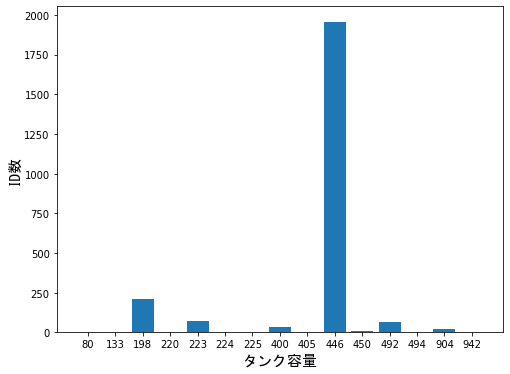

In [86]:
ticks = ["80", "133", "198", "220", "223", "224", "225", "400", "405", "446", "450", "492", "494",
            "904", "942"]
plt.rcParams['figure.figsize'] = [8, 6]
plt.bar(ticks, tanksize_unique_sorted)
plt.xlabel("タンク容量", fontname="MS Gothic",  fontsize=15)
plt.ylabel("顧客数", fontname="MS Gothic",  fontsize=15)



In [73]:
df_new.to_csv("./Appolo/appolo.csv", index = False)

In [46]:
interval = []

for i in range(1, df_new.shape[0]):
    if df_new.loc[i, "customer_id"] != df_new.loc[i - 1, "customer_id"]:
        interval.append("NaN")
    else:
        interval.append((df_new.loc[i, "supplied_at"] - df_new.loc[i - 1, "supplied_at"]).days)

interval = pd.Series(interval)
interval_count = interval.value_counts()
id_count = []

In [60]:
interval_count

NaN    2387
14     1648
30     1611
29     1536
28     1294
       ... 
272       1
324       1
409       1
386       1
491       1
Length: 340, dtype: int64

In [62]:
interval_count.drop(["NaN"], inplace=True)

In [67]:
processed_interval = interval_count[interval_count.index<100]

In [68]:
processed_interval

14    1648
30    1611
29    1536
28    1294
31    1294
      ... 
86       8
82       7
96       7
85       6
87       6
Length: 100, dtype: int64

Text(0, 0.5, '件数')

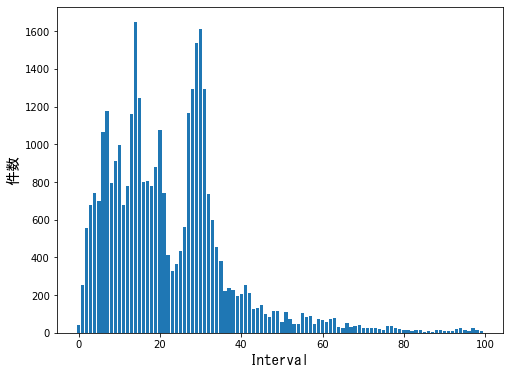

In [71]:
plt.rcParams['figure.figsize'] = [8, 6]
plt.bar(processed_interval.index, processed_interval)
plt.xlabel("Interval", fontname="MS Gothic",  fontsize=15)
plt.ylabel("件数", fontname="MS Gothic",  fontsize=15)

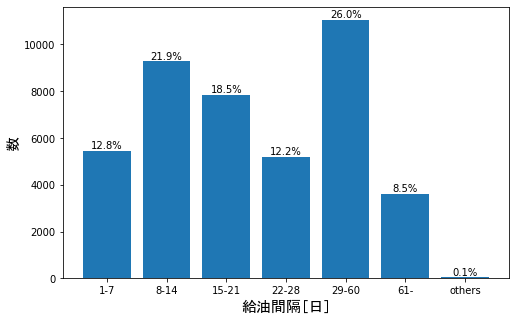

In [ ]:
dr.draw_interval_distribution(df_new, "顧客番号", "給油時間")